### All codes are written in Python and necessary QC checks are added in intermediate stages

## AI Potential Impact 

In [17]:
pip install sentence_transformers

  Using cached sentence_transformers-3.0.1-py3-none-any.whl.metadata (10 kB)
Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Import Necessary Libraries and dependencies 

In [12]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 8.2 MB/s eta 0:00:00:00:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import seaborn as sns
import pandas as pd
import numpy as np
import umap
import hdbscan
from sklearn.feature_extraction.text import CountVectorizer
from transformers import BertModel, BertTokenizer
import torch
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [21]:
df = pd.read_csv('customer_support.csv')

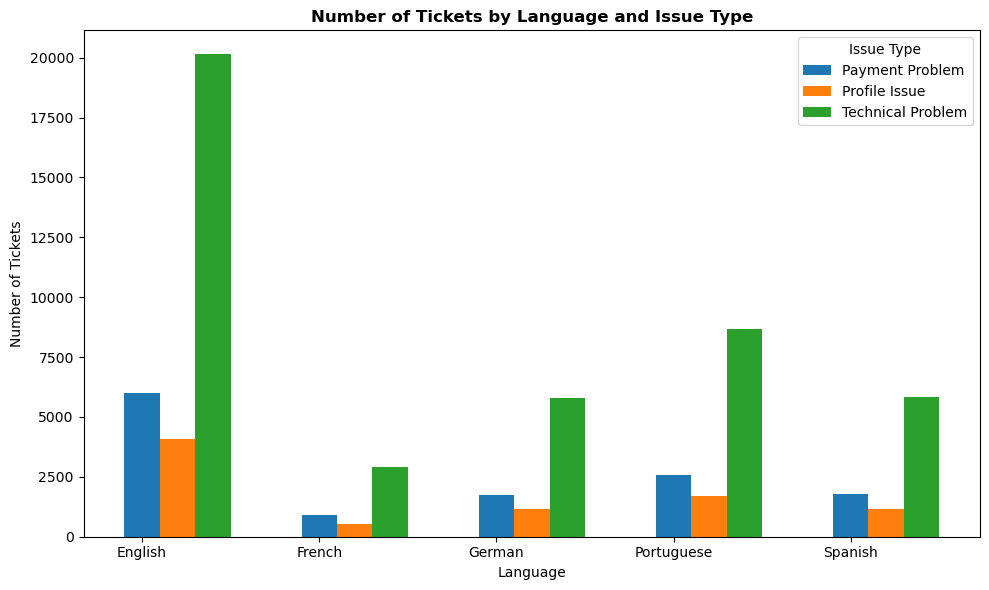

<Figure size 640x480 with 0 Axes>

In [3]:

# Group by 'language' and 'issue_type_category', then calculate count of distinct 'ticket_id'
grouped_data = df.groupby(['language', 'issue_type_category']).agg({'ticket_id': 'nunique'}).reset_index()
grouped_data.columns = ['language', 'issue_type_category', 'ticket_count']

languages = grouped_data['language'].unique()
issue_types = grouped_data['issue_type_category'].unique()
ticket_counts = grouped_data['ticket_count']

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting
bar_width = 0.2
x = range(len(languages))

for i, issue_type in enumerate(issue_types):
    ax.bar([pos + i * bar_width for pos in x], 
           ticket_counts[grouped_data['issue_type_category'] == issue_type], 
           width=bar_width, label=str(issue_type))  # Ensure issue_type is converted to string

ax.set_xlabel('Language')
ax.set_ylabel('Number of Tickets')
ax.set_title('Number of Tickets by Language and Issue Type',fontweight = 'bold')
ax.set_xticks(x)
ax.set_xticklabels(languages)
ax.legend(title='Issue Type')  # Set a title for the legend

plt.tight_layout()
plt.show()
plt.savefig("noofticketslanguageandissuetype.png")

In [22]:
df['ticket_creation_timestamp'] = pd.to_datetime(df['ticket_creation_timestamp'])
df['ticket_close_timestamp'] = pd.to_datetime(df['ticket_close_timestamp'], errors='coerce')

# Calculate resolution_time in hours
df['resolution_time'] = (df['ticket_close_timestamp'] - df['ticket_creation_timestamp']).dt.total_seconds() / 3600

# Set resolution_time to 0 for 'closed' or 'escalated' statuses
df.loc[df['ticket_status'].isin(['closed', 'escalated']), 'resolution_time'] = 0
df['resolution_time'] = df['resolution_time'].fillna(0)

/tmp/ipykernel_97/686578088.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ticket_close_timestamp'] = pd.to_datetime(df['ticket_close_timestamp'], errors='coerce')


### Cohort analysis to understand Customer groups 

In [4]:

df['interaction_date'] = pd.to_datetime(df['ticket_creation_timestamp'])


In [5]:
df['satisfaction_rating'] = pd.to_numeric(df['satisfaction_rating'], errors='coerce')

# Ensure repeat_contact is boolean
df['repeat_contact'] = df['repeat_contact'].astype(bool)

# Calculate the number of contacts and average satisfaction rating per user
user_metrics = df.groupby('user_id').agg({
    'ticket_id': 'size',  # Count of tickets
    'satisfaction_rating': 'mean',  # Average satisfaction rating
    'repeat_contact': 'sum'  # Sum of repeat contacts
}).reset_index()

user_metrics.rename(columns={
    'ticket_id': 'num_contacts',
    'satisfaction_rating': 'avg_satisfaction_rating',
    'repeat_contact': 'repeat_contact_count'
}, inplace=True)

# Define thresholds
frequent_threshold = 3
irritating_threshold = 2
low_satisfaction_threshold = 3.0

# Assign segments
def assign_segment(row):
    if row['num_contacts'] > frequent_threshold:
        return 'Frequent Visitor'
    elif row['num_contacts'] == 1:
        return 'Rare Visitor'
    elif row['repeat_contact_count'] >= irritating_threshold and row['avg_satisfaction_rating'] < low_satisfaction_threshold:
        return 'Irritating Customer'
    else:
        return 'Average Customer'

user_metrics['segment'] = user_metrics.apply(assign_segment, axis=1)

In [6]:
user_metrics['segment'].value_counts()

segment
Rare Visitor        64996
Average Customer        2
Name: count, dtype: int64

/tmp/ipykernel_97/1946441860.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='segment', data=user_metrics, palette='viridis')


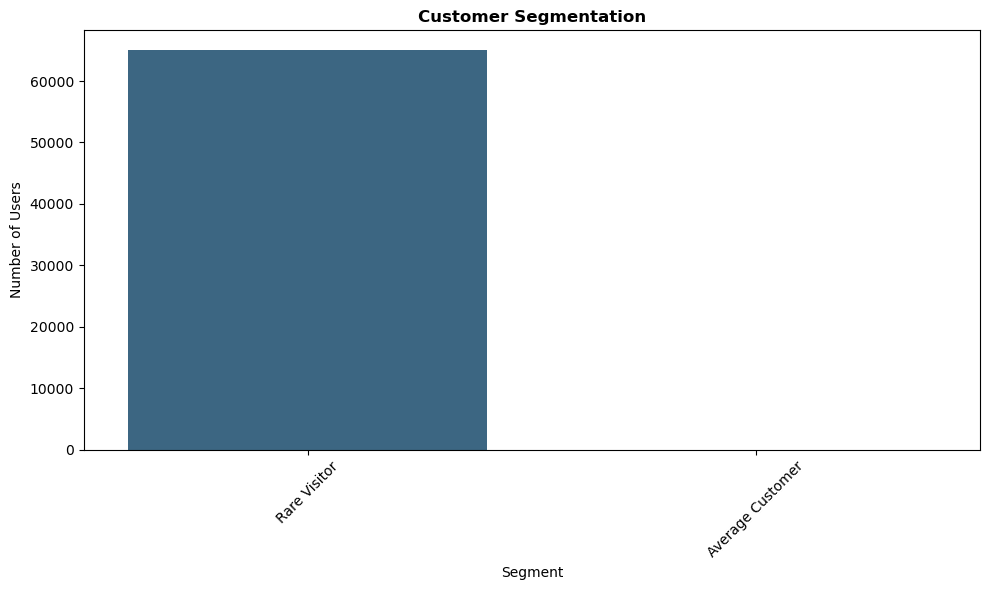

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x='segment', data=user_metrics, palette='viridis')
plt.title('Customer Segmentation', fontweight = 'bold')
plt.xlabel('Segment')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
user_metrics['segment'].value_counts()

segment
Rare Visitor        64996
Average Customer        2
Name: count, dtype: int64

### Find common themes using Clustering and Topic Modelling 

In [8]:
len(documents)

65000

In [6]:
# Select relevant columns for clustering
data = df[['issue_type_category', 'issue_type_sub_category']]

# Drop rows with missing values (if any)
data.dropna(inplace=True)

# Combine issue_type_category and issue_type_sub_category into a single text column
data['text'] = data['issue_type_category'] + ' ' + data['issue_type_sub_category']

documents = data['text'].tolist()

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=1000,  # Adjust the number of features as needed
                             stop_words='english', 
                             max_df=0.95, 
                             min_df=2)

# Fit and transform the documents
X = vectorizer.fit_transform(documents)

# Initialize KMeans with  number of clusters produced by elbow curve
num_clusters = 12  # Adjust as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans clustering model
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign cluster labels back to original data
data['cluster'] = cluster_labels

# Print clusters and their top terms, and store in a DataFrame
cluster_data = []

order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    cluster_info = {
        'Cluster': f"Cluster {i}",
        'Top Terms': [terms[ind] for ind in order_centroids[i, :10]]
    }
    cluster_data.append(cluster_info)

cluster_df = pd.DataFrame(cluster_data)

cluster_df.head(10)


/tmp/ipykernel_98/617695134.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)
/tmp/ipykernel_98/617695134.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'] = data['issue_type_category'] + ' ' + data['issue_type_sub_category']
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/tmp/ipykernel_98/617695134.

,Cluster,Top Terms
0,Cluster 0,"[showing, picture, change, profile, technical,..."
1,Cluster 1,"[cancel, subscription, know, payment, problem,..."
2,Cluster 2,"[chat, disappeared, technical, problem, verifi..."
3,Cluster 3,"[upload, photos, technical, problem, verificat..."
4,Cluster 4,"[matches, issue, technical, problem, verificat..."
5,Cluster 5,"[compliments, sending, issue, technical, probl..."
6,Cluster 6,"[purchase, old, new, restore, account, payment..."
7,Cluster 7,"[username, change, profile, issue, old, new, m..."
8,Cluster 8,"[opening, moves, setting, issue, technical, pr..."
9,Cluster 9,"[verification, photo, pass, technical, problem..."


### ELbow technique to estimate optimum number of clusters

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (13). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (14). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:1152: ConvergenceWarning: Number of distinct clusters (12) found smaller than n_clusters (15). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
/opt/conda/lib

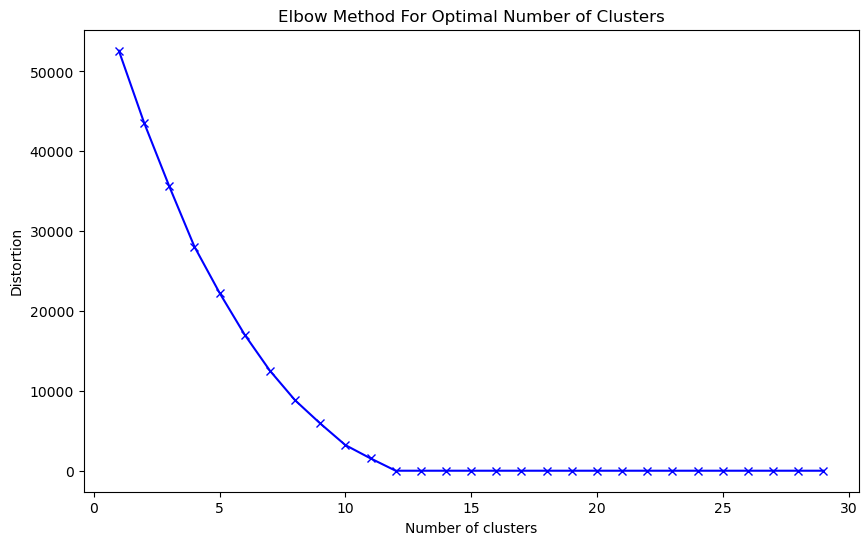

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# Calculate distortions for a range of number of clusters
distortions = []
K = range(1, 30) 
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    distortions.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.show()
plt.savefig("elbowcurve.png")

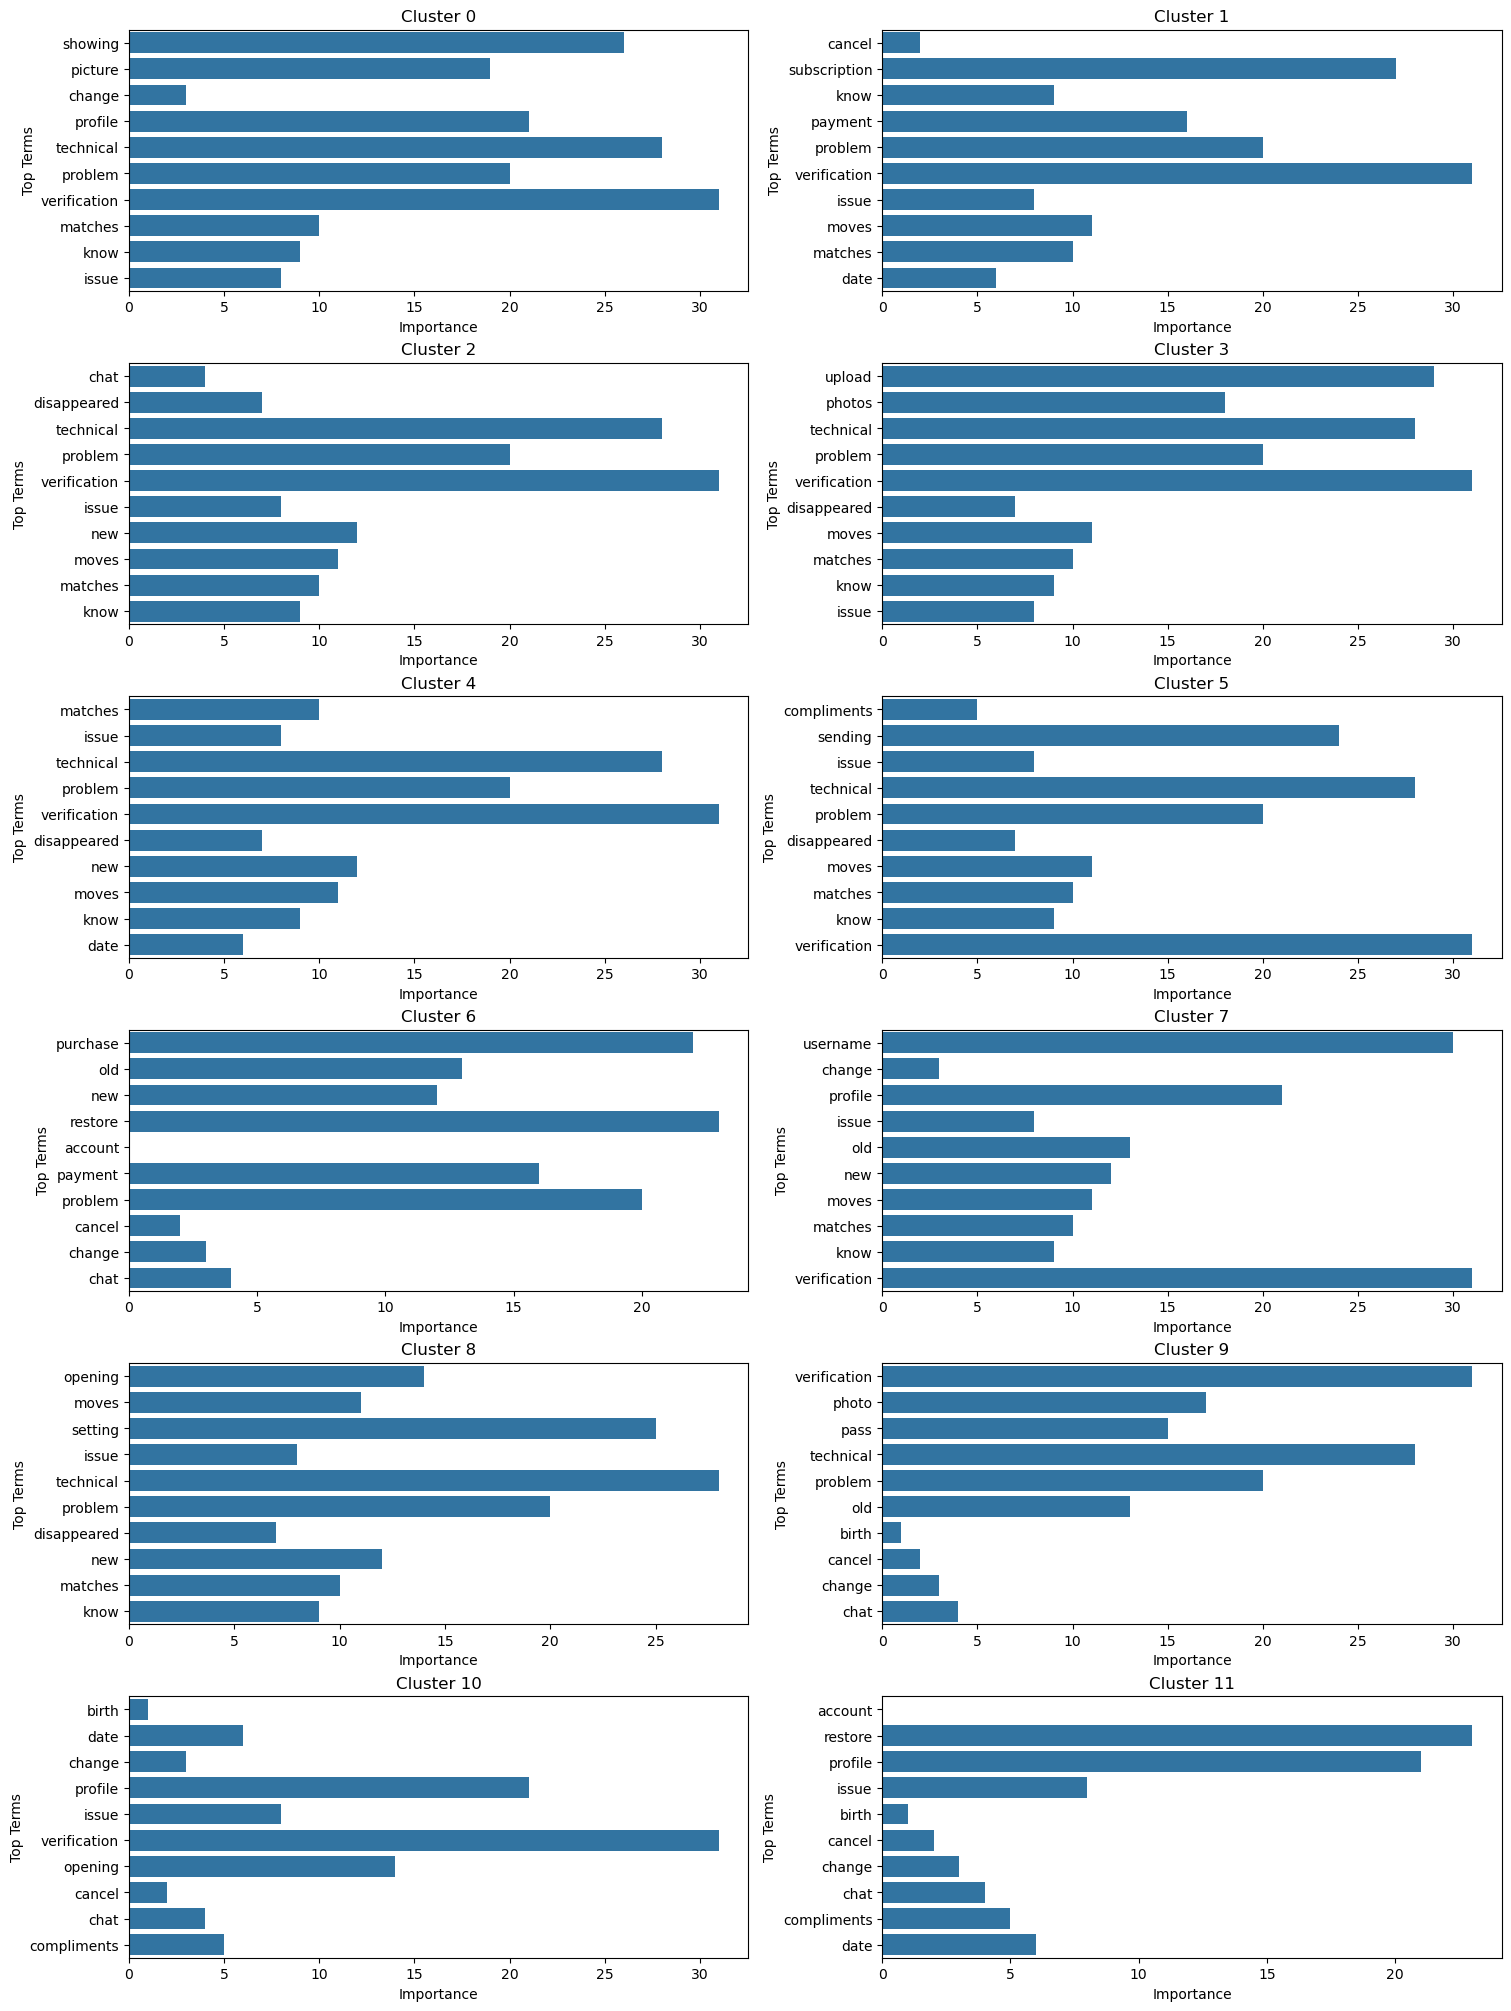

<Figure size 640x480 with 0 Axes>

In [8]:
fig, axes = plt.subplots(num_clusters // 2, 2, figsize=(15, 20), constrained_layout=True)
axes = axes.flatten()

for i, ax in enumerate(axes):
    top_terms = cluster_df.iloc[i]['Top Terms']
    term_importance = order_centroids[i, :10]
    
    sns.barplot(x=term_importance, y=top_terms, ax=ax)
    ax.set_title(f"Cluster {i}")
    ax.set_xlabel('Importance')
    ax.set_ylabel('Top Terms')

plt.show()
plt.savefig("clusterstopics.png")

### Topic Modelling Using BERT Sentence Transformers

In [10]:
from sentence_transformers import SentenceTransformer

# Load a BERT model
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encode the textual data
document_embeddings = model.encode(documents)


/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-07-10 17:09:10.169932: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-10 17:09:10.211392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 17:09:10.211441: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registere

In [11]:
# Initialize KMeans with desired number of clusters
num_clusters = 12  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)

# Fit KMeans clustering model
kmeans.fit(document_embeddings)

# Get cluster labels
cluster_labels = kmeans.labels_

# Assign cluster labels back to original data
data['cluster'] = cluster_labels

# Print clusters and their top terms
for cluster in range(num_clusters):
    cluster_data = data[data['cluster'] == cluster]
    print(f"Cluster {cluster}:")
    print(cluster_data['text'].head(10))  # Print example issues in this cluster
    print()


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster 0:
9      Technical Problem Profile Picture Cannot Chang...
39     Technical Problem Profile Picture Cannot Chang...
61     Technical Problem Profile Picture Cannot Chang...
142    Technical Problem Profile Picture Cannot Chang...
146    Technical Problem Profile Picture Cannot Chang...
156    Technical Problem Profile Picture Cannot Chang...
167    Technical Problem Profile Picture Cannot Chang...
184    Technical Problem Profile Picture Cannot Chang...
193    Technical Problem Profile Picture Cannot Chang...
204    Technical Problem Profile Picture Cannot Chang...
Name: text, dtype: object

Cluster 1:
3     Technical Problem Issue with Sending Compliments
11    Technical Problem Issue with Sending Compliments
15    Technical Problem Issue with Sending Compliments
29    Technical Problem Issue with Sending Compliments
38    Technical Problem Issue with Sending Compliments
40    Technical Problem Issue with Sending Compliments
47    Technical Problem Issue with Sending Complime

/tmp/ipykernel_98/1398442868.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cluster'] = cluster_labels


### Recommendations & Measurement Plans 

#### We can follow two approaches for measurment 
#### Approach 1 : T test - Create a test and control group and measure significance level 

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import seaborn as sns
import matplotlib.pyplot as plt

data = {
    'group': np.random.choice(['A', 'B'], size=65000),
    'resolution_time': df['resolution_time']  # resolution time in hours
}

df_test = pd.DataFrame(data)


In [25]:
# Calculate mean and standard deviation for resolution time for each group
metrics = df_test.groupby('group').agg(
    resolution_time_mean=('resolution_time', 'mean'),
    resolution_time_std=('resolution_time', 'std')
).reset_index()

print(metrics)


  group  resolution_time_mean  resolution_time_std
0     A              8.673334            12.086825
1     B              8.668967            12.216822


In [26]:
# Perform independent t-test for resolution times
resolution_time_A = df_test[df_test['group'] == 'A']['resolution_time']
resolution_time_B = df_test[df_test['group'] == 'B']['resolution_time']

t_stat_resolution, p_val_resolution_time = ttest_ind(resolution_time_A, resolution_time_B)

print(f"Resolution Time - t-statistic: {t_stat_resolution}, p-value: {p_val_resolution_time}")


Resolution Time - t-statistic: 0.04580545277922216, p-value: 0.9634654534036338


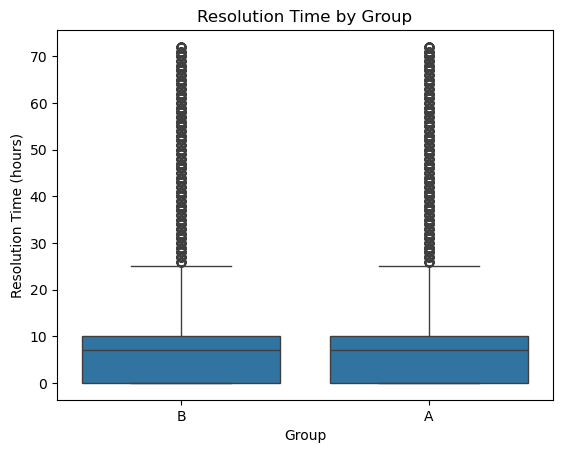

In [28]:
# Plot resolution times
sns.boxplot(x='group', y='resolution_time', data=df_test)
plt.title('Resolution Time by Group')
plt.xlabel('Group')
plt.ylabel('Resolution Time (hours)')
plt.show()


#### Testing Out sample chat BOT using Llama Parser

In [28]:
pip install llama_index

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 24.0 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 41.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 38.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.9/147.9 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.8/130.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.4/328.4 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.5/239.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [33]:
pip install dotenv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [76 lines of output]
      /opt/conda/lib/python3.10/site-packages/setuptools/__init__.py:80: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
        error: subprocess-exited-with-error
      
        × python setup.py egg_info did not run successfully.
        │ exit code: 1
        ╰─> [16 lines of output]
            Traceback (most recent call last):
              File "<string>",

### Create a sample chatbot using BUMBLE FAQ Page ---------for Measurement Testing Purpose

In [40]:
import os
import base64
from llama_index.core import StorageContext, load_index_from_storage, VectorStoreIndex, SimpleDirectoryReader, ChatPromptTemplate
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from dotenv import load_dotenv
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

In [39]:
pip install llama_index.embeddings.huggingface

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.2/853.2 kB 11.4 MB/s eta 0:00:0000:01

[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import requests
from bs4 import BeautifulSoup
from llama_index.core import StorageContext, load_index_from_storage, VectorStoreIndex, SimpleDirectoryReader, ChatPromptTemplate
from llama_index.llms.huggingface import HuggingFaceInferenceAPI
from dotenv import load_dotenv
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Settings

# Load environment variables
load_dotenv()

# Configure the Llama index settings
Settings.llm = HuggingFaceInferenceAPI(
    model_name="google/gemma-1.1-7b-it",
    tokenizer_name="google/gemma-1.1-7b-it",
    context_window=3000,
    token=os.getenv("HF_TOKEN"),
    max_new_tokens=512,
    generate_kwargs={"temperature": 0.1},
)
Settings.embed_model = HuggingFaceEmbedding(
    model_name="BAAI/bge-small-en-v1.5"
)

# Define the directory for persistent storage and data
PERSIST_DIR = "./db"
DATA_DIR = "data"

# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(PERSIST_DIR, exist_ok=True)

def data_ingestion(url):
    # Fetch the content from the URL
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Extract text from the page
    text_content = ''
    for paragraph in soup.find_all('p'):
        text_content += paragraph.get_text() + '\n'
    
    # Save the extracted text into a file in DATA_DIR
    text_file_path = os.path.join(DATA_DIR, "extracted_text.txt")
    with open(text_file_path, "w") as text_file:
        text_file.write(text_content)

    # Load data using SimpleDirectoryReader
    documents = SimpleDirectoryReader(DATA_DIR).load_data()
    storage_context = StorageContext.from_defaults()
    index = VectorStoreIndex.from_documents(documents)
    index.storage_context.persist(persist_dir=PERSIST_DIR)

def handle_query(query):
    storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)
    index = load_index_from_storage(storage_context)
    chat_text_qa_msgs = [
        (
            "user",
            """You are a customer support assistant for Bumble. Your main goal is to provide accurate answers to users' queries based on the information available in the help documents. If a question does not match the provided context or is outside the scope of the document, kindly advise the user to ask questions within the context of the document.
            Context:
            {context_str}
            Question:
            {query_str}
            """
        )
    ]
    text_qa_template = ChatPromptTemplate.from_messages(chat_text_qa_msgs)
    
    query_engine = index.as_query_engine(text_qa_template=text_qa_template)
    answer = query_engine.query(query)
    
    if hasattr(answer, 'response'):
        return answer.response
    elif isinstance(answer, dict) and 'response' in answer:
        return answer['response']
    else:
        return "Sorry, I couldn't find an answer."


# Step 1: Data Ingestion
url = "https://bumble.com/en/help-search?q=issue"
data_ingestion(url)

# Step 2: Query Handling
query = "Hi, I have an issue with the login page. Can you help?"
response = handle_query(query)
print(response)


/tmp/ipykernel_855/4027474218.py:14: DeprecationWarning: Call to deprecated class HuggingFaceInferenceAPI. (Deprecated in favor of `HuggingFaceInferenceAPI` from `llama-index-llms-huggingface-api` which should be used instead.)
  Settings.llm = HuggingFaceInferenceAPI(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]